In [1]:
# Configure ipython to hide long tracebacks.
import sys
ipython = get_ipython()

def minimal_traceback(*args, **kwargs):
  etype, value, tb = sys.exc_info()
  value.__cause__ = None  # suppress chained exceptions
  stb = ipython.InteractiveTB.structured_traceback(etype, value, tb)
  del stb[3:-1]
  return ipython._showtraceback(etype, value, stb)

ipython.showtraceback = minimal_traceback

# 用JAX的方式思考

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/thinking_in_jax.ipynb)

JAX提供了一个简单但强大的API来实现数值计算加速，但是如何用好JAX需要一点门槛。 本文档希望帮助你了解JAX是如何运行的，让你写出更加高效的代码。

## JAX vs. NumPy

**核心概念:**

- JAX提供类似NumPy的API，降低学习门槛。
- 通过鸭子类型（duck-typing），JAX数组通常可以无缝替换NumPy数组。
- 和NumPy数组不同，JAX数组是不可修改的（immutable）。

NumPy的API备受欢迎，为了降低JAX的学习门槛，`jax.numpy` 基本复刻了numpy API。 那些你使用`numpy`做的事情可以无缝切换到`jax.numpy`:

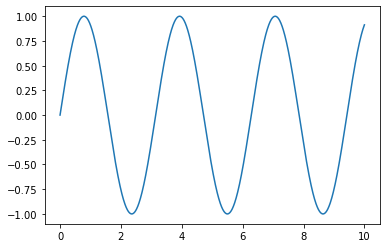

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np);

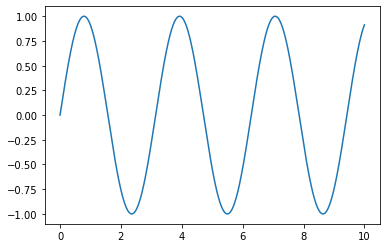

In [3]:
import jax.numpy as jnp

x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp);

上面的代码除了将`np` 替换为 `jnp`，其他一模一样，结果同样相同，在画图这件事上，可以用JAX数组替换NumPy数组。

实际上，二者的类型是不同的:

In [4]:
type(x_np)

numpy.ndarray

In [5]:
type(x_jnp)

jaxlib.xla_extension.DeviceArray

Python的[鸭子类型（duck-typing）](https://en.wikipedia.org/wiki/Duck_typing) 机制使得JAX数组和NumPy数组在很多场景中可以任意切换。

但是，一定要记住：JAX数组是不可修改的（immutable），什么意思呢？一旦数组被创建，数组内的值就不可以被改变。

NumPy数组是可以修改的:

In [6]:
# NumPy: mutable arrays
x = np.arange(10)
x[0] = 10
print(x)

[10  1  2  3  4  5  6  7  8  9]


同样的代码，JAX数组就报错:

In [7]:
# JAX: immutable arrays
x = jnp.arange(10)
x[0] = 10

TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

如果想更新JAX数组中某个元素的值，JAX提供了[indexed update syntax](https://jax.readthedocs.io/en/latest/jax.ops.html#indexed-update-operators)，返回一个新的数组:

In [8]:
y = x.at[0].set(10)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[10  1  2  3  4  5  6  7  8  9]


## NumPy, lax & XLA: JAX的多层API

**核心概念:**

- `jax.numpy` 是一个高层的API，提供接近NumPy的用户体验
- `jax.lax` 是一个底层的API，虽然更加严格但是功能更强大
- 所有的JAX算子本质上都是由[XLA](https://www.tensorflow.org/xla/)中的算子实现的

如果你去看 `jax.numpy`的源码，你会发现所有的计算/算子最终都是用 `jax.lax`中的算子来实现的，你可以认为 `jax.lax` 是一个更加严格但是功能更强大的对多维数组进行操作的API。

为什么说`jax.lax`更严格，举个例子， `jax.numpy` 隐式的支持混合数据类型计算（自动进行类型转换），但是`jax.lax`不允许：

In [9]:
import jax.numpy as jnp
jnp.add(1, 1.0)  # jax.numpy API implicitly promotes mixed types.

DeviceArray(2., dtype=float32, weak_type=True)

In [10]:
from jax import lax
lax.add(1, 1.0)  # jax.lax API requires explicit type promotion.

TypeError: lax.add requires arguments to have the same dtypes, got int32, float32. (Tip: jnp.add is a similar function that does automatic type promotion on inputs).

如果使用 `jax.lax` API，必须显式的进行类型转换：

In [11]:
lax.add(jnp.float32(1), 1.0)

DeviceArray(2., dtype=float32)

虽然语法更严格，但是也带来了更高的效率，比如，1维卷积：


In [12]:
x = jnp.array([1, 2, 1])
y = jnp.ones(10)
jnp.convolve(x, y)

DeviceArray([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

JAX引擎会将`jnp.convolve` 解析为更通用的 [`lax.conv_general_dilated`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.conv_general_dilated.html):

In [13]:
from jax import lax
result = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float),  # note: explicit promotion
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)])  # equivalent of padding='full' in NumPy
result[0, 0]

DeviceArray([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

这是一个支持batch卷积操作的算子，虽然写法啰嗦点，但是却更加灵活。

实际上，所有的 `jax.lax` 算子都是对XLA算子的Python封装，比如，上面的卷积实际上调用了 [XLA:ConvWithGeneralPadding](https://www.tensorflow.org/xla/operation_semantics#convwithgeneralpadding_convolution)。

每一个JAX算子最终都会解析成XLA算子，所以才支持JIT编译。

## To JIT or not to JIT

**核心概念:**

- 默认情况下，JAX以序列的形式每次执行一条指令
- 使用JIT (just-in-time)编译，一组指令可以进行优化，执行一次
- 不是所有的JAX代码都支持JIT编译，前提条件是在编译阶段数组的shape是固定且已知的

前面讲过，所有的JAX算子都会被翻译成XLA算子，所以JAX才可以使用XLA编译器来高效的执行代码。

比如，下面的函数用于对二维矩阵的每一列进行正则化，此处使用 `jax.numpy` :

In [14]:
import jax.numpy as jnp

def norm(X):
  X = X - X.mean(0)
  return X / X.std(0)

可以利用`jax.jit`得到JIT编译的函数：

In [15]:
from jax import jit
norm_compiled = jit(norm)

JIT编译后的函数，语义含义并不会变:

In [26]:
np.random.seed(1701)
X = jnp.array(np.random.rand(10000, 10))
np.allclose(norm(X), norm_compiled(X), atol=1E-6)

True

由于使用了JIT编译（可能引入了算子融合（fusing of operations）、避免分配临时数组以及其他各种tricks），执行效率可能快几个数量级:

In [27]:
%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

516 µs ± 28.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
168 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


当然了， `jax.jit` 也不是万能的，它要求涉及的所有数组都有固定的shape，所以某些JAX算子就不支持JIT编译。

看个例子，下面的函数不使用JIT时，执行起来没毛病：

In [28]:
def get_negatives(x):
  return x[x < 0]

x = jnp.array(np.random.randn(10))
get_negatives(x)

DeviceArray([-0.10570311, -0.59403396, -0.8680282 , -0.23489487], dtype=float32)

但是它不支持JIT编译:

In [29]:
jit(get_negatives)(x)

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got ShapedArray(bool[10])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

这个函数的输出是一个数组，但是这个数组的shape在编译阶段是无法确定的，因为它依赖于输入数组的值，所以这个函数就不支持JIT编译。

## JIT 机制: tracing and static variables

**核心概念:**

- JIT和其他的JAX转换（transforms）都依靠对函数进行 *tracing* 来确定这个函数适用的数组shape和类型。

- 那些你不想trace的变量（varibles），可以被标记为 *static*

只有理解了 `jax.jit` 的工作原理，才能更好的使用它。让我们在一个JIT编译过的函数内部添加几个 `print()` :

In [32]:
@jit
def f(x, y):
  print("Running f():")
  print(f"  x = {x}")
  print(f"  y = {y}")
  result = jnp.dot(x + 1, y + 1)
  print(f"  result = {result}")
  return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
f(x, y)

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=0/1)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=0/1)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=0/1)>


DeviceArray([1.4344587, 4.3004417, 7.989701 ], dtype=float32)

In [33]:
f(x, y)

DeviceArray([1.4344587, 4.3004417, 7.989701 ], dtype=float32)

注意print语句确实执行了，但是打印的却并不是函数传参的值，而是x和y的 *tracer* 对象。

 `jax.jit` 借助这些tracer对象来确定函数中都包含哪些必要的算子（计算操作）。 基本的tracer对象包含了数组的 **shape** 和 **dtype** 信息，不包含数组的值。只要后面调用函数时的传参保持相同的shape和dtype，这个JIT编译的函数可以直接使用XLA执行，无需对函数的Python源码重新编译。

当我们第二次调用f函数，由于传参的shape和dtype相同，不需要重新编译，可以看到，没有再执行print语句，因为代码是在XLA上执行而不是Python，print语句已经被优化了:

In [34]:
x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
f(x2, y2)

DeviceArray([4.1002445, 5.468004 , 1.5471637], dtype=float32)

`jax.jit`将函数中抽取出来的必要算子（计算操作）编码为JAX表达式，简称为 *jaxpr* . 可以利用`jax.make_jaxpr` 转换查看jaxpr:

In [35]:
from jax import make_jaxpr

def f(x, y):
  return jnp.dot(x + 1, y + 1)

make_jaxpr(f)(x, y)

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(((1,), (0,)), ((), ()))
      precision=None
      preferred_element_type=None
    ] c d
  in (e,) }

注意：由于JIT编译过程不涉及数组的值，所以函数内的条件语句（if-else）不能搭配tracer对象:

In [37]:
@jit
def f(x, neg):
  return -x if neg else x

f(1, True)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
While tracing the function f at /tmp/ipykernel_321960/2422663986.py:1 for jit, this concrete value was not available in Python because it depends on the value of the argument 'neg'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

如果某个变量不想被trace，可以将其标记为static:

In [38]:
from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
  return -x if neg else x

f(1, True)

DeviceArray(-1, dtype=int32, weak_type=True)

注意，如果使用一个不同的static参数，调用JIT编译的函数，会导致函数重新编译，保证函数正确执行:

In [40]:
f(1, False)

DeviceArray(1, dtype=int32, weak_type=True)

只有理解了哪些变量应该static，哪些应该traced，才算是理解了 `jax.jit` 。

## Static vs Traced 算子

**核心概念:**

- 变量可以是static或traced，算子也可以是static或traced

- static算子在Python编译期执行，traced算子在XLA的运行时编译和执行？

- 那些想static的算子使用 `numpy`，那些想traced的算子使用 `jax.numpy`

看个例子:

In [41]:
import jax.numpy as jnp
from jax import jit

@jit
def f(x):
  return x.reshape(jnp.array(x.shape).prod())

x = jnp.ones((2, 3))
f(x)

TypeError: Shapes must be 1D sequences of concrete values of integer type, got [Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>].
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.

上面的函数进行JIT编译失败，错误原因是reshape函数接受的参数必须是具体的shape值而不是抽象的tracer对象，让我们添加几个print语句来看下到底发生了什么:

In [43]:
@jit
def f(x):
  print(f"x = {x}")
  print(f"x.shape = {x.shape}")
  print(f"jnp.array(x.shape).prod() = {jnp.array(x.shape).prod()}")
  # comment this out to avoid the error:
  # return x.reshape(jnp.array(x.shape).prod())

f(x)

x = Traced<ShapedArray(float32[2,3])>with<DynamicJaxprTrace(level=0/1)>
x.shape = (2, 3)
jnp.array(x.shape).prod() = Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>


注意虽然x被trace，但是`x.shape`是静态的值（static value），然而，当我们又进行了 `jnp.array` 和 `jnp.prod` 操作，又变成了traced value，无法作为`reshape`函数的传参。

建议使用 `numpy` 来操作那些应该是static的计算（在编译期进行），使用 `jax.numpy` 来应对traced计算（在运行时编译和执行），:

In [44]:
from jax import jit
import jax.numpy as jnp
import numpy as np

@jit
def f(x):
  return x.reshape((np.prod(x.shape),))

f(x)

DeviceArray([1., 1., 1., 1., 1., 1.], dtype=float32)

处于这种原因，在JAX程序中建议同时 `import numpy as np` 和 `import jax.numpy as jnp` ，合理利用np和jnp来控制那些算子使用np执行（static，编译期），哪些使用jnp执行（traced，运行时优化）。